# Satellite images classification

## Upload data

First of all, I am going to import the images from my device

In [1]:
from google.colab import files
uploaded= files.upload()

Saving Ground_files.zip to Ground_files.zip


Now, as I have imported a .zip. The file has to be extracted

In [2]:

#Carga de datos
import zipfile
import io
data= zipfile.ZipFile(io.BytesIO(uploaded['Ground_files.zip']), 'r')
data.extractall()


## Exploratory data Analysis


In the first cell, libraries requiered will be imported

In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img #Generate different img: dealing with overfitting
from keras import optimizers #optimizers for the CNN
from keras.models import Sequential #to create the model arcitecture
from keras.layers import Dropout, Flatten, Dense, Activation  #layers
from keras.layers import Convolution2D, MaxPooling2D #layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau #callbacks
from keras.applications import VGG19,ResNet50,ResNet101,InceptionV3,MobileNetV2 #pre-trained CNNfrom keras.layers import Input, Dense, GlobalAveragePooling2D #layers

In this problem, we need to use a GPU to accelerate the classification. For this reason, I am going to use the free GPU that Google Colab gives to all his users. Thus, I check if it is avaliable

In [4]:

print('GPU is available !!!' if tf.config.list_physical_devices('GPU') else 'GPU is not available')

#GPU 
tf.config.list_physical_devices('GPU')

GPU is available !!!


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Once the data is extracted it is neccesary to define the path to the images. My file has two folders: "train" and "validacion". But first, I am going to work only with the training path

In [23]:
data_train = './train/train' 

Let's define the fit model parameters. if a change need to be done, I would only have to modify this cell

In [24]:
classes= 45 # number of classes in our dataset
epochs = 30
batch_size = 32
height, length = 256, 256

It's time to preprocess the images. This would generate variations of the images which will help the model to understand the patroons needed to do an optimal classification. It is very important for many reasons:

- The accuracy in validation would be next to the accuracy in train
- This would help to avoid the overfitting
- Changing this parameters, we can control how the model learn

However, is very important not to do a big preproccesing due to the fact that the images can be changed and it will decieve our model.
Notice that only the train images have to be preprocessed. In validation, we want the images with the same shape as in test.

In [35]:
# Image preprocesing

datagen_train = ImageDataGenerator(
        rescale=1./255,   #Normalize => Training more effective
        zoom_range= 0.2, #Take zoom to some images
        horizontal_flip= True,  #Randomly flip inputs horizontally
        shear_range=0.1, #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
        rotation_range = 30, #Degree range for random rotations
        brightness_range = [0.8,1], #Range for picking a brightness shift value from
        width_shift_range=0.1,
        height_shift_range=0.1,
        validation_split=0.3 #Fraction of images reserved for validation
        )

datagen_val = ImageDataGenerator(
    rescale = 1./255. ,
    validation_split=0.3
)

#Load the images

training_images = datagen_train.flow_from_directory(
        data_train,
        target_size=(height,length),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training' ,
        color_mode ='rgb'
        )

validation_images = datagen_val.flow_from_directory(
        data_train,
        target_size=(height,length),
        batch_size= batch_size,
        class_mode= 'categorical',
        subset='validation' ,
        color_mode ='rgb'
        )

Found 17263 images belonging to 45 classes.
Found 7394 images belonging to 45 classes.


In [36]:
#See the labels

print('\nTraining labels are:' , training_images.class_indices )
print('\nValidation labels are:' , validation_images.class_indices)


Training labels are: {'airplane': 0, 'airport': 1, 'baseball_diamond': 2, 'basketball_court': 3, 'beach': 4, 'bridge': 5, 'chaparral': 6, 'church': 7, 'circular_farmland': 8, 'cloud': 9, 'commercial_area': 10, 'dense_residential': 11, 'desert': 12, 'forest': 13, 'freeway': 14, 'golf_course': 15, 'ground_track_field': 16, 'harbor': 17, 'industrial_area': 18, 'intersection': 19, 'island': 20, 'lake': 21, 'meadow': 22, 'medium_residential': 23, 'mobile_home_park': 24, 'mountain': 25, 'overpass': 26, 'palace': 27, 'parking_lot': 28, 'railway': 29, 'railway_station': 30, 'rectangular_farmland': 31, 'river': 32, 'roundabout': 33, 'runway': 34, 'sea_ice': 35, 'ship': 36, 'snowberg': 37, 'sparse_residential': 38, 'stadium': 39, 'storage_tank': 40, 'tennis_court': 41, 'terrace': 42, 'thermal_power_station': 43, 'wetland': 44}

Validation labels are: {'airplane': 0, 'airport': 1, 'baseball_diamond': 2, 'basketball_court': 3, 'beach': 4, 'bridge': 5, 'chaparral': 6, 'church': 7, 'circular_farmla

It goes without saying that computers understand a number better than a string. Thus, I encode the labels

In [37]:
labels = training_images.class_indices
labels = dict((v,k) for k,v in labels.items())
labels 

{0: 'airplane',
 1: 'airport',
 2: 'baseball_diamond',
 3: 'basketball_court',
 4: 'beach',
 5: 'bridge',
 6: 'chaparral',
 7: 'church',
 8: 'circular_farmland',
 9: 'cloud',
 10: 'commercial_area',
 11: 'dense_residential',
 12: 'desert',
 13: 'forest',
 14: 'freeway',
 15: 'golf_course',
 16: 'ground_track_field',
 17: 'harbor',
 18: 'industrial_area',
 19: 'intersection',
 20: 'island',
 21: 'lake',
 22: 'meadow',
 23: 'medium_residential',
 24: 'mobile_home_park',
 25: 'mountain',
 26: 'overpass',
 27: 'palace',
 28: 'parking_lot',
 29: 'railway',
 30: 'railway_station',
 31: 'rectangular_farmland',
 32: 'river',
 33: 'roundabout',
 34: 'runway',
 35: 'sea_ice',
 36: 'ship',
 37: 'snowberg',
 38: 'sparse_residential',
 39: 'stadium',
 40: 'storage_tank',
 41: 'tennis_court',
 42: 'terrace',
 43: 'thermal_power_station',
 44: 'wetland'}

These are some images to classify. Notice that they are without any change because they are images from the validation set

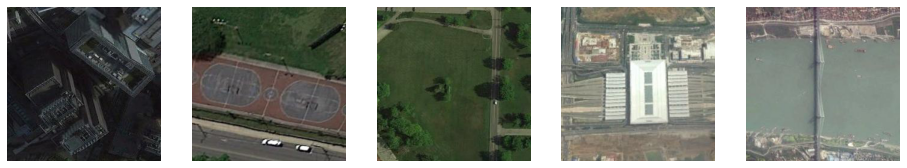

In [38]:
#Plot some images with withoutpreprocessing load

fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(16,16))


for i in range (5):
    
    image = next(validation_images)[0][0] # getting images
    
    image = np.squeeze(image) 
    
    ax[i].imshow(image)
    ax[i].axis('off')

Now, let's see random images from the training set. That is to say, with preproccesing

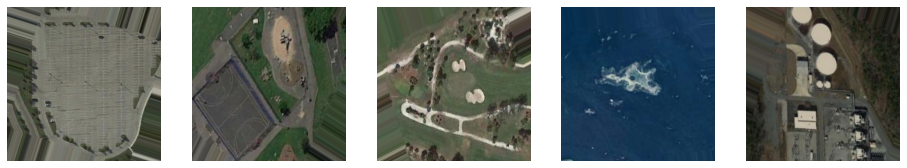

In [39]:
#Plot some images with preprocessing load

fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(16,16))


for i in range (5):
    
    image = next(training_images)[0][0] # getting images
    
    image = np.squeeze(image) 
    
    ax[i].imshow(image)
    ax[i].axis('off')


## Model

Callbacks are very important to control the training

In [12]:
#Define the callbacks

stop = EarlyStopping(monitor='accuracy', patience=4, verbose=1, min_delta=1e-4)
reduce= ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=2, cooldown=2, verbose=1)

The final target of this problem is to compare some pre-trained neuronal networks from Keras. So, I define a generic model and then I am going to create them with a specific pre-trained neuronal network

In [13]:
#Define a generic model

def build_model(transfer_learning):

      #for layer in transfer_learning:
        #layer.trainable = False


      model = Sequential(transfer_learning)
      model.add(GlobalAveragePooling2D(name='pool_2d'))
      model.add(Dense(512,activation = 'relu'))
      model.add(Dropout(0.3))
      model.add(Dense(256,activation = 'relu'))
      model.add(Dropout(0.2))
      model.add(Dense(256,activation = 'relu'))
      model.add(Dropout(0.15))
      model.add(Dense(classes,activation='softmax'))

      print(model.summary())

      model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



      return model


Starting with ResNet50

In [ ]:
#Build ResNet50

model1 = build_model(ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3)))

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
pool_2d (GlobalAveragePoolin (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________

In [ ]:
#Fitting the model

model1.fit(training_images, epochs = epochs, validation_data = validation_images , callbacks = [stop,reduce] , verbose = 1)

Epoch 1/30
540/540 [==============================] - 343s 611ms/step - loss: 3.3375 - accuracy: 0.1362 - val_loss: 18.4007 - val_accuracy: 0.0233
Epoch 2/30
540/540 [==============================] - 319s 590ms/step - loss: 2.0664 - accuracy: 0.3962 - val_loss: 3.6624 - val_accuracy: 0.2165
Epoch 3/30
540/540 [==============================] - 314s 582ms/step - loss: 1.5765 - accuracy: 0.5386 - val_loss: 1.3763 - val_accuracy: 0.6066
Epoch 4/30
540/540 [==============================] - 310s 574ms/step - loss: 1.2435 - accuracy: 0.6330 - val_loss: 1.3750 - val_accuracy: 0.6072
Epoch 5/30
540/540 [==============================] - 305s 565ms/step - loss: 1.0524 - accuracy: 0.6897 - val_loss: 1.0890 - val_accuracy: 0.6938
Epoch 6/30
540/540 [==============================] - 301s 558ms/step - loss: 0.9183 - accuracy: 0.7301 - val_loss: 1.3334 - val_accuracy: 0.6289
Epoch 7/30
540/540 [==============================] - 302s 560ms/step - loss: 0.8122 - accuracy: 0.7545 - val_loss: 1.7332 

This has been a good training, we can see the results with the following visualization

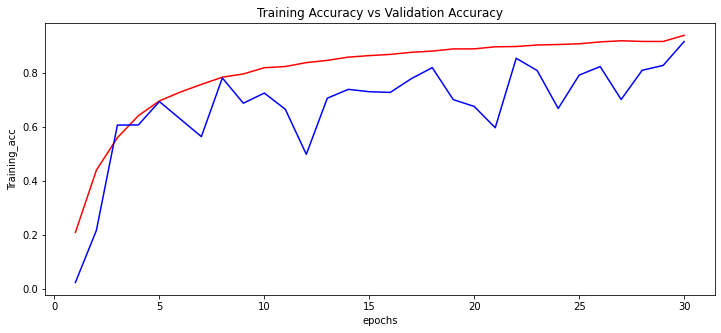

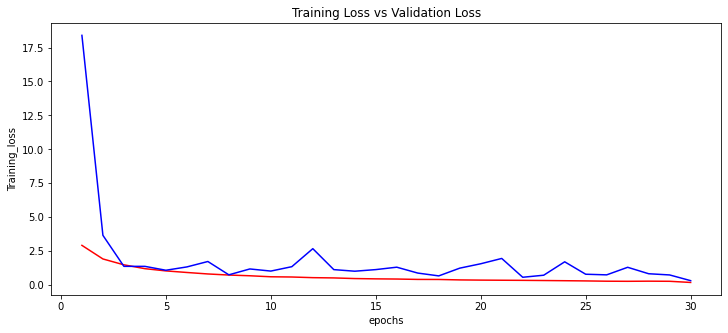

In [ ]:
#Visualization of accuracy and loss

results1 = pd.DataFrame({'epochs':list(range(1,epochs+1)),'Training_acc':model1.history.history['accuracy'],'Validation_acc':model1.history.history['val_accuracy'],
                      'Training_loss':model1.history.history['loss'],'Validation_loss':model1.history.history['val_loss']})

plt.figure(figsize=(12,5))
sns.lineplot(x = 'epochs', y ='Training_acc', data = results1, color='r' )
sns.lineplot(x = 'epochs', y ='Validation_acc', data = results1, color='blue' )
plt.title('Training Accuracy vs Validation Accuracy')
plt.show()

plt.figure(figsize=(12,5))
sns.lineplot(x = 'epochs', y ='Training_loss', data = results1, color='r' )
sns.lineplot(x = 'epochs', y ='Validation_loss', data = results1, color='blue' )
plt.title('Training Loss vs Validation Loss')
plt.show()

Turn to the VGG19

In [ ]:
#Build VGG19

model2 = build_model(VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3)))

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
pool_2d (GlobalAveragePoolin (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_______________________________________________________

In [ ]:
#Fitting the model

model2.fit(training_images, epochs = epochs, validation_data = validation_images , callbacks = [stop,reduce] , verbose = 1)

Epoch 1/30
540/540 [==============================] - 325s 596ms/step - loss: 4.2365 - accuracy: 0.0226 - val_loss: 3.8010 - val_accuracy: 0.0227
Epoch 2/30
540/540 [==============================] - 314s 581ms/step - loss: 3.8016 - accuracy: 0.0212 - val_loss: 3.8004 - val_accuracy: 0.0227
Epoch 3/30
540/540 [==============================] - 313s 579ms/step - loss: 3.8007 - accuracy: 0.0209 - val_loss: 3.7999 - val_accuracy: 0.0227
Epoch 4/30
540/540 [==============================] - 313s 580ms/step - loss: 3.8011 - accuracy: 0.0216 - val_loss: 3.7998 - val_accuracy: 0.0227
Epoch 5/30
540/540 [==============================] - 316s 585ms/step - loss: 3.8005 - accuracy: 0.0231 - val_loss: 3.7999 - val_accuracy: 0.0227
Epoch 6/30
540/540 [==============================] - 311s 575ms/step - loss: 3.8009 - accuracy: 0.0213 - val_loss: 3.7996 - val_accuracy: 0.0229
Epoch 7/30
540/540 [==============================] - 311s 576ms/step - loss: 3.8008 - accuracy: 0.0199 - val_loss: 3.7996 -

This neuronal network couldn't find any patroon. Let's check the ResNet101

In [ ]:
#Build ResNet101

model3 = build_model(ResNet101(weights='imagenet', include_top=False, input_shape=(256, 256, 3)))

171450368/171446536 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 8, 8, 2048)        42658176  
_________________________________________________________________
pool_2d (GlobalAveragePoolin (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_______________________________________________________

In [ ]:
#Fitting the model

model3.fit(training_images, epochs = epochs, validation_data = validation_images , callbacks = [stop,reduce] , verbose = 1)

Epoch 1/30
540/540 [==============================] - 339s 594ms/step - loss: 3.7331 - accuracy: 0.0532 - val_loss: 14.3658 - val_accuracy: 0.0227
Epoch 2/30
540/540 [==============================] - 316s 585ms/step - loss: 3.0137 - accuracy: 0.1533 - val_loss: 3.5834 - val_accuracy: 0.1413
Epoch 3/30
540/540 [==============================] - 312s 578ms/step - loss: 2.5171 - accuracy: 0.2685 - val_loss: 3.9302 - val_accuracy: 0.2545
Epoch 4/30
540/540 [==============================] - 308s 570ms/step - loss: 2.1731 - accuracy: 0.3490 - val_loss: 3.0434 - val_accuracy: 0.2705
Epoch 5/30
540/540 [==============================] - 307s 569ms/step - loss: 1.8735 - accuracy: 0.4359 - val_loss: 1.7856 - val_accuracy: 0.4761
Epoch 6/30
540/540 [==============================] - 325s 602ms/step - loss: 1.6566 - accuracy: 0.5027 - val_loss: 10.5010 - val_accuracy: 0.2369
Epoch 7/30
540/540 [==============================] - 314s 581ms/step - loss: 1.4956 - accuracy: 0.5452 - val_loss: 2.2427

The main fail in this traning is the gap between train and validation. due to we have other options, this will be discarded

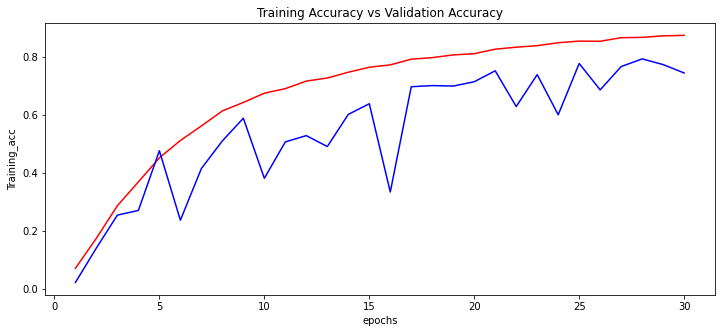

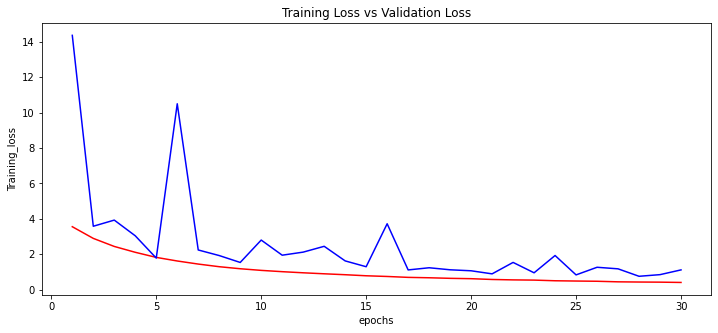

In [ ]:
#Visualization of accuracy and loss

results3 = pd.DataFrame({'epochs':list(range(1,epochs+1)),'Training_acc':model3.history.history['accuracy'],'Validation_acc':model3.history.history['val_accuracy'],
                      'Training_loss':model3.history.history['loss'],'Validation_loss':model3.history.history['val_loss']})

plt.figure(figsize=(12,5))
sns.lineplot(x = 'epochs', y ='Training_acc', data = results3, color='r' )
sns.lineplot(x = 'epochs', y ='Validation_acc', data = results3, color='blue' )
plt.title('Training Accuracy vs Validation Accuracy')
plt.show()

plt.figure(figsize=(12,5))
sns.lineplot(x = 'epochs', y ='Training_loss', data = results3, color='r' )
sns.lineplot(x = 'epochs', y ='Validation_loss', data = results3, color='blue' )
plt.title('Training Loss vs Validation Loss')
plt.show()

Time of InceptionV3

In [ ]:
#Build InceptionV3

model4 = build_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3)))

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
pool_2d (GlobalAveragePoolin (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________

In [ ]:
#Fitting the model

model4.fit(training_images, epochs = epochs, validation_data = validation_images , callbacks = [stop,reduce] , verbose = 1)

Epoch 1/30
540/540 [==============================] - 298s 529ms/step - loss: 3.6520 - accuracy: 0.0539 - val_loss: 3.7284 - val_accuracy: 0.1443
Epoch 2/30
540/540 [==============================] - 280s 517ms/step - loss: 2.7840 - accuracy: 0.1967 - val_loss: 4.3396 - val_accuracy: 0.1183
Epoch 3/30
540/540 [==============================] - 279s 517ms/step - loss: 2.2989 - accuracy: 0.2997 - val_loss: 3.1883 - val_accuracy: 0.2894
Epoch 4/30
540/540 [==============================] - 279s 517ms/step - loss: 1.9844 - accuracy: 0.4037 - val_loss: 2.4781 - val_accuracy: 0.3692
Epoch 5/30
540/540 [==============================] - 278s 515ms/step - loss: 1.7325 - accuracy: 0.4664 - val_loss: 1.7500 - val_accuracy: 0.4942
Epoch 6/30
540/540 [==============================] - 278s 515ms/step - loss: 1.5181 - accuracy: 0.5401 - val_loss: 1.2467 - val_accuracy: 0.6181
Epoch 7/30
540/540 [==============================] - 279s 516ms/step - loss: 1.3809 - accuracy: 0.5822 - val_loss: 1.5591 -

Apart from a good accuracy in training this model has something really positive, it has a validation accuracy next to the training accuracy

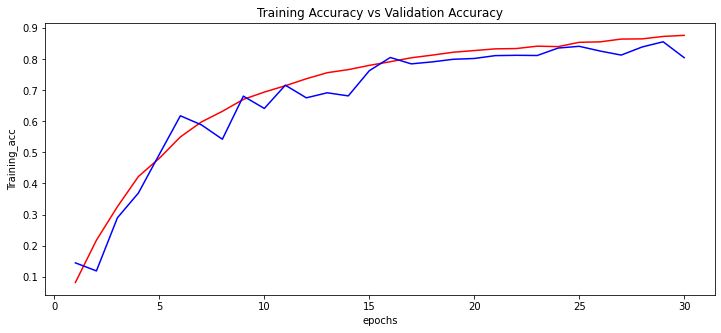

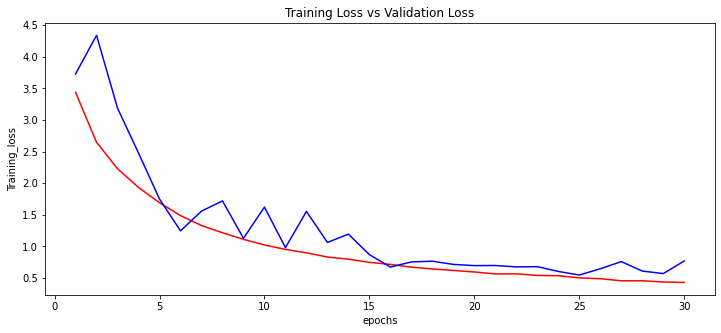

In [ ]:
#Visualization of accuracy and loss

results4 = pd.DataFrame({'epochs':list(range(1,epochs+1)),'Training_acc':model4.history.history['accuracy'],'Validation_acc':model4.history.history['val_accuracy'],
                      'Training_loss':model4.history.history['loss'],'Validation_loss':model4.history.history['val_loss']})

plt.figure(figsize=(12,5))
sns.lineplot(x = 'epochs', y ='Training_acc', data = results4, color='r' )
sns.lineplot(x = 'epochs', y ='Validation_acc', data = results4, color='blue' )
plt.title('Training Accuracy vs Validation Accuracy')
plt.show()

plt.figure(figsize=(12,5))
sns.lineplot(x = 'epochs', y ='Training_loss', data = results4, color='r' )
sns.lineplot(x = 'epochs', y ='Validation_loss', data = results4, color='blue' )
plt.title('Training Loss vs Validation Loss')
plt.show()

Finishing with MobileNetV2

In [14]:
#Build MobileNetV2

model5 = build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3)))

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
pool_2d (GlobalAveragePoolin (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
___________________________________________________________

In [15]:
#Fitting the model

model5.fit(training_images, epochs = epochs, validation_data = validation_images , callbacks = [stop,reduce] , verbose = 1)

Epoch 1/30
540/540 [==============================] - 342s 613ms/step - loss: 2.6844 - accuracy: 0.2851 - val_loss: 22.5655 - val_accuracy: 0.0227
Epoch 2/30
540/540 [==============================] - 327s 605ms/step - loss: 1.2471 - accuracy: 0.6414 - val_loss: 6.8880 - val_accuracy: 0.0930
Epoch 3/30
540/540 [==============================] - 326s 603ms/step - loss: 0.9808 - accuracy: 0.7310 - val_loss: 5.6255 - val_accuracy: 0.1473
Epoch 4/30
540/540 [==============================] - 327s 606ms/step - loss: 0.8273 - accuracy: 0.7713 - val_loss: 7.1633 - val_accuracy: 0.2241
Epoch 5/30
540/540 [==============================] - 327s 605ms/step - loss: 0.7444 - accuracy: 0.7931 - val_loss: 4.5167 - val_accuracy: 0.2598
Epoch 6/30
540/540 [==============================] - 325s 602ms/step - loss: 0.7133 - accuracy: 0.8071 - val_loss: 4.1459 - val_accuracy: 0.3151
Epoch 7/30
540/540 [==============================] - 326s 603ms/step - loss: 0.6543 - accuracy: 0.8198 - val_loss: 4.1185 

This model started the training very bad, however, in each epoch it is getting a better validation accuracy. Probably, to extract all his potential a different set up would be necessary

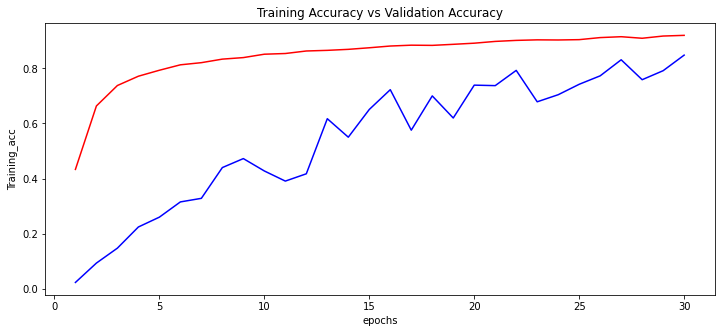

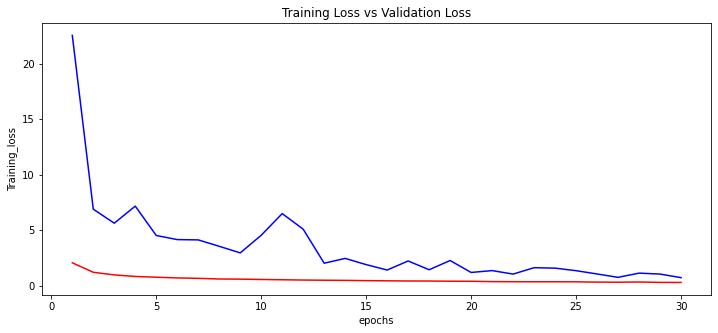

In [16]:
#Visualization of accuracy and loss

results5 = pd.DataFrame({'epochs':list(range(1,epochs+1)),'Training_acc':model5.history.history['accuracy'],'Validation_acc':model5.history.history['val_accuracy'],
                      'Training_loss':model5.history.history['loss'],'Validation_loss':model5.history.history['val_loss']})

plt.figure(figsize=(12,5))
sns.lineplot(x = 'epochs', y ='Training_acc', data = results5, color='r' )
sns.lineplot(x = 'epochs', y ='Validation_acc', data = results5, color='blue' )
plt.title('Training Accuracy vs Validation Accuracy')
plt.show()

plt.figure(figsize=(12,5))
sns.lineplot(x = 'epochs', y ='Training_loss', data = results5, color='r' )
sns.lineplot(x = 'epochs', y ='Validation_loss', data = results5, color='blue' )
plt.title('Training Loss vs Validation Loss')
plt.show()

## Prediction

To conclude, I am going to use the last model to create a prediction

In [18]:
#Use the model5 for making predictions

data_test = data_train = './validacion' 

datagen_test = ImageDataGenerator(
    rescale = 1./255.
)

test_images = datagen_test.flow_from_directory(
        data_test,
        target_size=(height,length),
        batch_size= batch_size,
        class_mode= 'categorical' ,
        color_mode ='rgb'
        )


preds = model5.predict(test_images)

Found 3080 images belonging to 1 classes.


In [19]:
#Get the indices

pred_class_indices = np.argmax(preds,axis=1)
pred_class_indices[0:15]

array([38,  5, 32, 22, 30, 21, 37,  9, 32, 43, 15, 16,  9,  8,  8])

In [20]:
#Get the Label

label_names = [labels[k] for k in pred_class_indices]
label_names[0:15]

['sparse_residential',
 'bridge',
 'river',
 'meadow',
 'railway_station',
 'lake',
 'snowberg',
 'cloud',
 'river',
 'thermal_power_station',
 'golf_course',
 'ground_track_field',
 'cloud',
 'circular_farmland',
 'circular_farmland']